# Replicación Artículo: Forecasting Short Term Photovoltaic Power Model Based on Improved Snake Optimization, Convolutional Neural Network and Bidirectional Long Short-Term Memory Network

In [1]:
import warnings
warnings.filterwarnings("ignore")

Leemos los datos

In [2]:
import pandas as pd
datos = pd.read_excel("02.Generación Pearson.xlsx")
datos["Generacion_prev_hour"] = datos["Generación"].shift(1)
datos = datos.dropna(how="any", axis= 0)
datos.index = pd.to_datetime(datos['Fecha'], format='%Y-%m-%d %H:%M:%s')
datos = datos.drop(columns='Fecha', axis=1)
datos.head(4)

,Generación,Índice UV,Temperatura,Hora,DPT,Cobertura Nubes,Condición Cielo,Humedad Relativa,Generacion_prev_hour
Fecha,,,,,,,,,
2022-09-01 01:00:00,0.0,0.0,19,1,16,82,4,82,0.0
2022-09-01 02:00:00,0.0,0.0,18,2,16,73,3,85,0.0
2022-09-01 03:00:00,0.0,0.0,18,3,16,63,3,87,0.0
2022-09-01 04:00:00,0.0,0.0,18,4,16,70,3,88,0.0


In [3]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18289 entries, 2022-09-01 01:00:00 to 2024-10-03 00:00:00
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Generación            18289 non-null  float64
 1   Índice UV             18289 non-null  float64
 2   Temperatura           18289 non-null  int64  
 3   Hora                  18289 non-null  int64  
 4   DPT                   18289 non-null  int64  
 5   Cobertura Nubes       18289 non-null  int64  
 6   Condición Cielo       18289 non-null  int64  
 7   Humedad Relativa      18289 non-null  int64  
 8   Generacion_prev_hour  18289 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 1.4 MB


In [4]:
datos.describe().T

,count,mean,std,min,25%,50%,75%,max
Generación,18289.0,9392.983969,11398.764291,0.0,0.0,533.0,21830.0,30000.0
Índice UV,18289.0,1.976418,3.181404,0.0,0.0,0.0,3.0,14.0
Temperatura,18289.0,19.456723,6.636719,0.0,15.0,19.0,24.0,39.0
Hora,18289.0,12.500683,6.922804,1.0,7.0,13.0,19.0,25.0
DPT,18289.0,9.837881,4.803705,0.0,6.0,10.0,14.0,20.0
Cobertura Nubes,18289.0,50.305594,37.864498,0.0,12.0,48.0,92.0,100.0
Condición Cielo,18289.0,2.675816,1.493514,1.0,1.0,3.0,4.0,5.0
Humedad Relativa,18289.0,58.878233,26.112575,3.0,37.0,62.0,83.0,100.0
Generacion_prev_hour,18289.0,9392.983969,11398.764291,0.0,0.0,533.0,21830.0,30000.0


División de datos en Soleado, nublado y lluvioso

In [5]:
datos.columns

Index(['Generación', 'Índice UV', 'Temperatura', 'Hora', 'DPT',
       'Cobertura Nubes', 'Condición Cielo', 'Humedad Relativa',
       'Generacion_prev_hour'],
      dtype='object')

In [6]:
datosX = datos[['Índice UV', 'Temperatura', 'Hora', 'DPT',
       'Cobertura Nubes', 'Condición Cielo', 'Humedad Relativa',
       'Generacion_prev_hour']]

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(datosX)

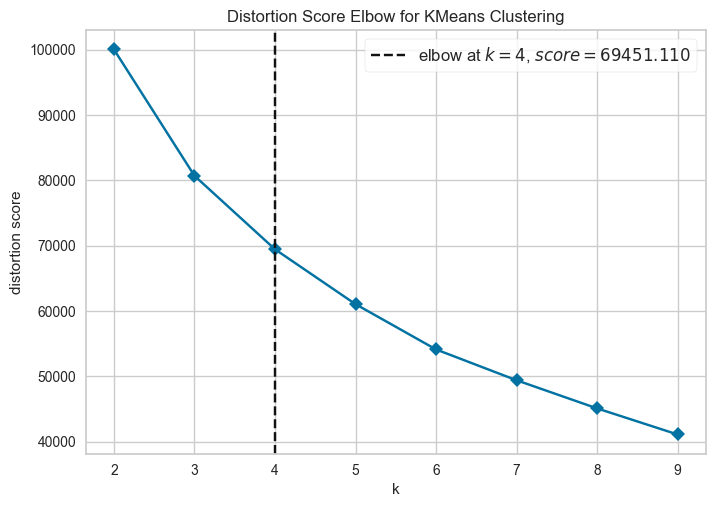

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
# Determinar el número óptimo de clusters usando el método del codo
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(2,10), metric='distortion', timings=False)
visualizer.fit(X_scaled)
visualizer.show()

In [9]:
# Elegimos el mejor número de clusters basado en la gráfica del codo
K_optimo = visualizer.elbow_value_
K_optimo

np.int64(4)

In [10]:
# Aplicar K-Means con el número óptimo de clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

In [11]:
datos['Cluster'] = clusters
datos

,Generación,Índice UV,Temperatura,Hora,DPT,Cobertura Nubes,Condición Cielo,Humedad Relativa,Generacion_prev_hour,Cluster
Fecha,,,,,,,,,,
2022-09-01 01:00:00,0.0,0.0,19,1,16,82,4,82,0.0,3
2022-09-01 02:00:00,0.0,0.0,18,2,16,73,3,85,0.0,3
2022-09-01 03:00:00,0.0,0.0,18,3,16,63,3,87,0.0,3
2022-09-01 04:00:00,0.0,0.0,18,4,16,70,3,88,0.0,3
2022-09-01 05:00:00,0.0,0.0,17,5,14,45,3,86,0.0,3
...,...,...,...,...,...,...,...,...,...,...
2024-10-02 20:00:00,0.0,0.0,22,20,9,2,1,45,1450.0,0
2024-10-02 21:00:00,0.0,0.0,20,21,10,1,1,54,0.0,0
2024-10-02 22:00:00,0.0,0.0,18,22,11,0,1,62,0.0,0


In [12]:
print(datos['Cluster'].value_counts())
# Calcular estadísticas de cada cluster
cluster_means = datos.groupby('Cluster').mean()
cluster_means


Cluster
2    4778
3    4722
0    4554
1    4235
Name: count, dtype: int64


,Generación,Índice UV,Temperatura,Hora,DPT,Cobertura Nubes,Condición Cielo,Humedad Relativa,Generacion_prev_hour
Cluster,,,,,,,,,
0,3208.819993,0.523518,16.774923,12.077295,9.688845,11.037330,1.170400,64.265261,2052.067032
1,8180.778603,1.119835,20.248406,18.490437,10.364817,82.131759,3.973554,55.802125,9605.164827
2,22885.030243,5.754835,26.519674,14.665969,7.940561,28.739640,1.707828,31.594391,24387.580048
3,2792.258718,0.322639,14.186362,5.346040,11.428844,81.454680,3.943244,84.049132,1110.004241


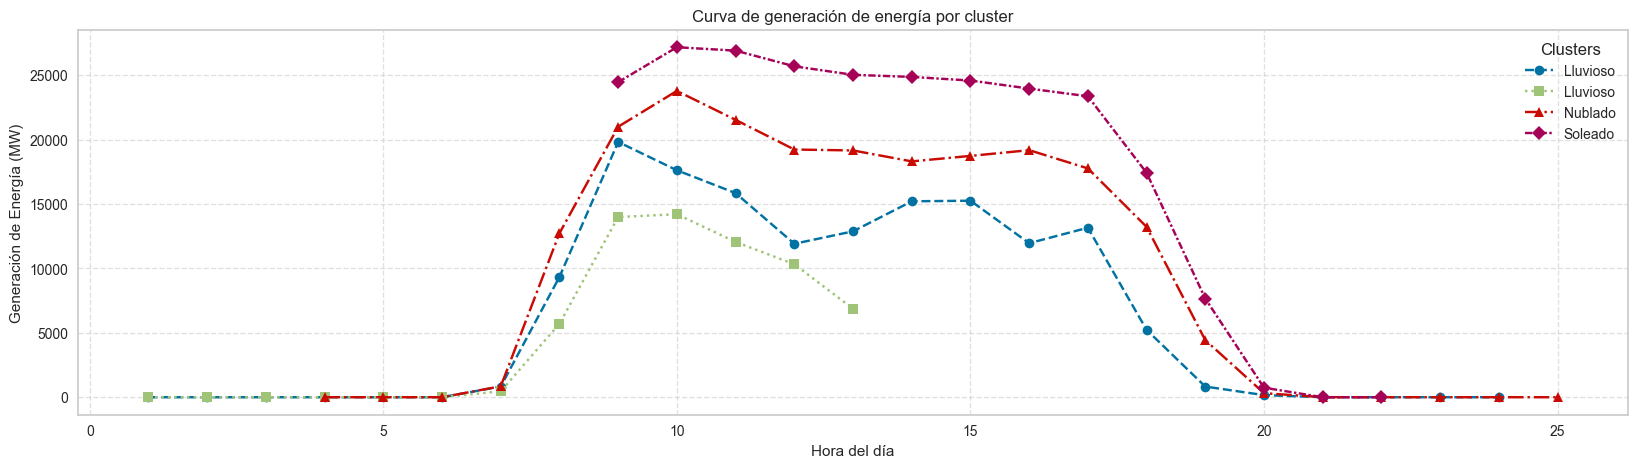

In [13]:
import matplotlib.pyplot as plt
df_grouped = datos.groupby(['Hora', 'Cluster'])['Generación'].mean().reset_index()

plt.figure(figsize=(20,5))

clusters = df_grouped['Cluster'].unique()

# Definir estilos para cada cluster
line_styles = ['dashed', 'dotted', 'dashdot', (0, (3, 1, 1, 1)), (0, (5, 1))]
markers = ['o', 's', '^', 'D', 'x']

# Dibujar una línea para cada cluster
for i, cluster in enumerate(clusters):
    if cluster == 0:
        label = 'Lluvioso'
    if cluster == 1:
        label = 'Nublado'
    if cluster == 2:
        label = 'Soleado'
    subset = df_grouped[df_grouped['Cluster'] == cluster]
    plt.plot(subset['Hora'], subset['Generación'], 
             linestyle=line_styles[i % len(line_styles)], 
             marker=markers[i % len(markers)], 
             label=label)

# Configuración de la gráfica
plt.xlabel("Hora del día")
plt.ylabel("Generación de Energía (MW)")
plt.title("Curva de generación de energía por cluster")
plt.legend(title="Clusters")
plt.grid(True, linestyle="--", alpha=0.6)

# Mostrar la gráfica
plt.show()

Como el artículo no menciona el porcentaje de entrenamiento, usaremos 70-15-15.

Tomemos en cuenta que: cluster == 0: 'Lluvioso', cluster == 1: 'Nublado', cluster == 2: 'Soleado'

In [14]:
import numpy as np
def datos_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

División en x y y.

El artículo tampoco menciona la ventana de tiempo que usaron, así que pondremos 5 como default

In [15]:
WINDOW_SIZE = 10
X_Soleado, y_Soleado = datos_to_X_y(datos[datos['Cluster']==2].drop(columns='Cluster', axis=1), WINDOW_SIZE)
X_Nublado, y_Nublado = datos_to_X_y(datos[datos['Cluster']==1].drop(columns='Cluster', axis=1), WINDOW_SIZE)
X_Lluvioso, y_Lluvioso = datos_to_X_y(datos[datos['Cluster']==0].drop(columns='Cluster', axis=1), WINDOW_SIZE)
X_Soleado.shape, y_Soleado.shape, X_Nublado.shape, y_Nublado.shape, X_Lluvioso.shape, y_Lluvioso.shape

((4768, 10, 9), (4768,), (4225, 10, 9), (4225,), (4544, 10, 9), (4544,))

Cálculos para el 70-15-15

In [16]:
num_datos_Soleado = X_Soleado.shape[0]
train_Soleado = int(round(num_datos_Soleado * 0.7,0))
val_Soleado = int(train_Soleado + round((num_datos_Soleado - train_Soleado) / 2, 0))

num_datos_Nublado = X_Nublado.shape[0]
train_Nublado = int(round(num_datos_Nublado * 0.7,0))
val_Nublado = int(train_Nublado + round((num_datos_Nublado - train_Nublado) / 2, 0))

num_datos_Lluvioso = X_Lluvioso.shape[0]
train_Lluvioso = int(round(num_datos_Lluvioso * 0.7,0))
val_Lluvioso = int(train_Lluvioso + round((num_datos_Lluvioso - train_Lluvioso) / 2, 0))

num_datos_Soleado, train_Soleado, val_Soleado, num_datos_Nublado, train_Nublado, val_Nublado, num_datos_Lluvioso, train_Lluvioso, val_Lluvioso

(4768, 3338, 4053, 4225, 2958, 3592, 4544, 3181, 3863)

División entrenamiento, validación y prueba


In [17]:
X_Soleado_train, y_Soleado_train = X_Soleado[:train_Soleado], y_Soleado[:train_Soleado]
X_Soleado_val, y_Soleado_val = X_Soleado[train_Soleado:val_Soleado], y_Soleado[train_Soleado:val_Soleado]
X_Soleado_test, y_Soleado_test = X_Soleado[val_Soleado:], y_Soleado[val_Soleado:]
X_Soleado_train.shape, y_Soleado_train.shape, X_Soleado_val.shape, y_Soleado_val.shape, X_Soleado_test.shape, y_Soleado_test.shape

((3338, 10, 9), (3338,), (715, 10, 9), (715,), (715, 10, 9), (715,))

In [18]:
X_Nublado_train, y_Nublado_train = X_Nublado[:train_Nublado], y_Nublado[:train_Nublado]
X_Nublado_val, y_Nublado_val = X_Nublado[train_Nublado:val_Nublado], y_Nublado[train_Nublado:val_Nublado]
X_Nublado_test, y_Nublado_test = X_Nublado[val_Nublado:], y_Nublado[val_Nublado:]
X_Nublado_train.shape, y_Nublado_train.shape, X_Nublado_val.shape, y_Nublado_val.shape, X_Nublado_test.shape, y_Nublado_test.shape

((2958, 10, 9), (2958,), (634, 10, 9), (634,), (633, 10, 9), (633,))

In [19]:
X_Lluvioso_train, y_Lluvioso_train = X_Lluvioso[:train_Lluvioso], y_Lluvioso[:train_Lluvioso]
X_Lluvioso_val, y_Lluvioso_val = X_Lluvioso[train_Lluvioso:val_Lluvioso], y_Lluvioso[train_Lluvioso:val_Lluvioso]
X_Lluvioso_test, y_Lluvioso_test = X_Lluvioso[val_Lluvioso:], y_Lluvioso[val_Lluvioso:]
X_Lluvioso_train.shape, y_Lluvioso_train.shape, X_Lluvioso_val.shape, y_Lluvioso_val.shape, X_Lluvioso_test.shape, y_Lluvioso_test.shape

((3181, 10, 9), (3181,), (682, 10, 9), (682,), (681, 10, 9), (681,))

Definición del modelo

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [21]:
features = X_Soleado_train.shape[0]

In [406]:
model_Soleado = Sequential()
model_Soleado.add(InputLayer((WINDOW_SIZE, 9)))

#CNN
model_Soleado.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'))
model_Soleado.add(BatchNormalization())  # 🔹 Nueva Normalización aquí
model_Soleado.add(MaxPooling1D(pool_size=2))

#model_Soleado.add(Flatten())
#BiLSTM
model_Soleado.add(Bidirectional(LSTM(128, return_sequences=True)))
model_Soleado.add(Bidirectional(LSTM(64, return_sequences=True)))
model_Soleado.add(Dropout(0.2))  # 🔹 Mayor regularización en BiLSTM
model_Soleado.add(Bidirectional(LSTM(32, return_sequences=False)))

#Normalización y Dropout
model_Soleado.add(BatchNormalization())
model_Soleado.add(Dropout(0.3))

# Capas Densas
model_Soleado.add(Dense(16, activation='relu'))
model_Soleado.add(Dense(1, 'relu'))

model_Soleado.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_36 (Conv1D)              │ (None, 10, 64)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_33 (MaxPooling1D) │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_64                │ (None, 5, 256)         │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_65                │ (None, 5, 128)         │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_66                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 405,985 (1.55 MB)

 Trainable params: 405,729 (1.55 MB)

 Non-trainable params: 256 (1.00 KB)

In [24]:
from tensorflow.keras.losses import Huber

In [408]:
cp = ModelCheckpoint('Forcasting_model_Soleado.keras', save_best_only=True)
model_Soleado.compile(optimizer=Adam(learning_rate=0.0001), loss=Huber(delta=1000), metrics=['mae'])

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [369]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_Soleado_train = scaler_X.fit_transform(X_Soleado_train.reshape(-1, X_Soleado_train.shape[-1])).reshape(X_Soleado_train.shape)
X_Soleado_val = scaler_X.transform(X_Soleado_val.reshape(-1, X_Soleado_val.shape[-1])).reshape(X_Soleado_val.shape)
X_Soleado_test = scaler_X.transform(X_Soleado_test.reshape(-1, X_Soleado_test.shape[-1])).reshape(X_Soleado_test.shape)

y_Soleado_train = scaler_y.fit_transform(y_Soleado_train.reshape(-1, 1)).reshape(-1)
y_Soleado_val = scaler_y.transform(y_Soleado_val.reshape(-1, 1)).reshape(-1)
y_Soleado_test = scaler_y.transform(y_Soleado_test.reshape(-1, 1)).reshape(-1)


In [370]:
X_Soleado_train.shape, y_Soleado_train.shape, X_Soleado_val.shape, y_Soleado_val.shape, X_Soleado_test.shape, y_Soleado_test.shape

((4093, 10, 9), (4093,), (877, 10, 9), (877,), (877, 10, 9), (877,))

In [371]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)


In [412]:
history = model_Soleado.fit(X_Soleado_train, y_Soleado_train, validation_data=(X_Soleado_val, y_Soleado_val), epochs=100, batch_size=8, callbacks=[cp, early_stop])

Epoch 1/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - loss: 0.0115 - mae: 0.1114 - val_loss: 0.0128 - val_mae: 0.0933
Epoch 2/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - loss: 0.0117 - mae: 0.1102 - val_loss: 0.0167 - val_mae: 0.1039
Epoch 3/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 0.0118 - mae: 0.1103 - val_loss: 0.0116 - val_mae: 0.0876
Epoch 4/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - loss: 0.0108 - mae: 0.1060 - val_loss: 0.0118 - val_mae: 0.0901
Epoch 5/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - loss: 0.0108 - mae: 0.1050 - val_loss: 0.0124 - val_mae: 0.0912
Epoch 6/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 38s 36ms/step - loss: 0.0100 - mae: 0.1017 - val_loss: 0.0145 - val_mae: 0.0965
Epoch 7/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - loss: 0.0097 - mae: 0.0999 - val_loss: 0.0135 - val_mae: 0.0874
Epoch 8/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - loss: 0.0108 - mae: 0.1026 - val_loss: 0.0120 - val_mae: 0.0883
Epoch 9/100
512/512 ━━━━━━━━━━━━

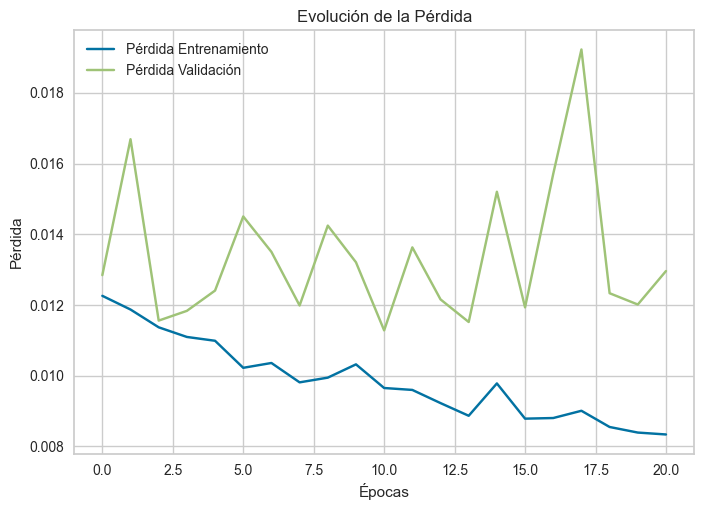

In [413]:
import matplotlib.pyplot as plt

# Extraer la pérdida del historial
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear la gráfica
plt.plot(train_loss, label='Pérdida Entrenamiento')
plt.plot(val_loss, label='Pérdida Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolución de la Pérdida')
plt.legend()
plt.grid(True)
plt.show()


In [35]:
from sklearn.metrics import mean_absolute_percentage_error as mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error as mean_absolute_error
from sklearn.metrics import mean_squared_error as mean_squared_error
from sklearn.metrics import r2_score as r2_score
def plot_predictions1(model, X, y, scaler_y, start=0, end=100):
    predictions = model.predict(X).flatten()
    y = y.flatten()
    predictions_original = scaler_y.inverse_transform(predictions.reshape(-1, 1)).reshape(-1)
    predictions_original = np.clip(predictions_original, 0, 30000)
    y_original = scaler_y.inverse_transform(y.reshape(-1, 1)).reshape(-1)
    df = pd.DataFrame(data={'Predictions': predictions_original, 'Actuals': y_original})
    plt.figure(figsize=(20, 5))
    print(f"MAE: {mean_absolute_error(y_original, predictions_original):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_original, predictions_original)):.4f}")
    print(f"R²: {r2_score(y_original, predictions_original):.4f}")
    plt.plot(y_original, label='Valor Real', color='blue')
    plt.plot(predictions_original, label='Predicción', color='red', linestyle='dashed')
    plt.xlabel("Hora")
    plt.ylabel("Valor")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    return df

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
MAE: 2509.9100
RMSE: 3880.8193
R²: 0.6634


,Predictions,Actuals
0,25759.826172,22788.0
1,26190.437500,29354.0
2,28042.835938,29193.0
3,28315.199219,29220.0
4,28874.947266,28971.0
...,...,...
872,24108.628906,25399.0
873,25231.251953,25562.0
874,25649.718750,25386.0
875,24499.578125,22872.0


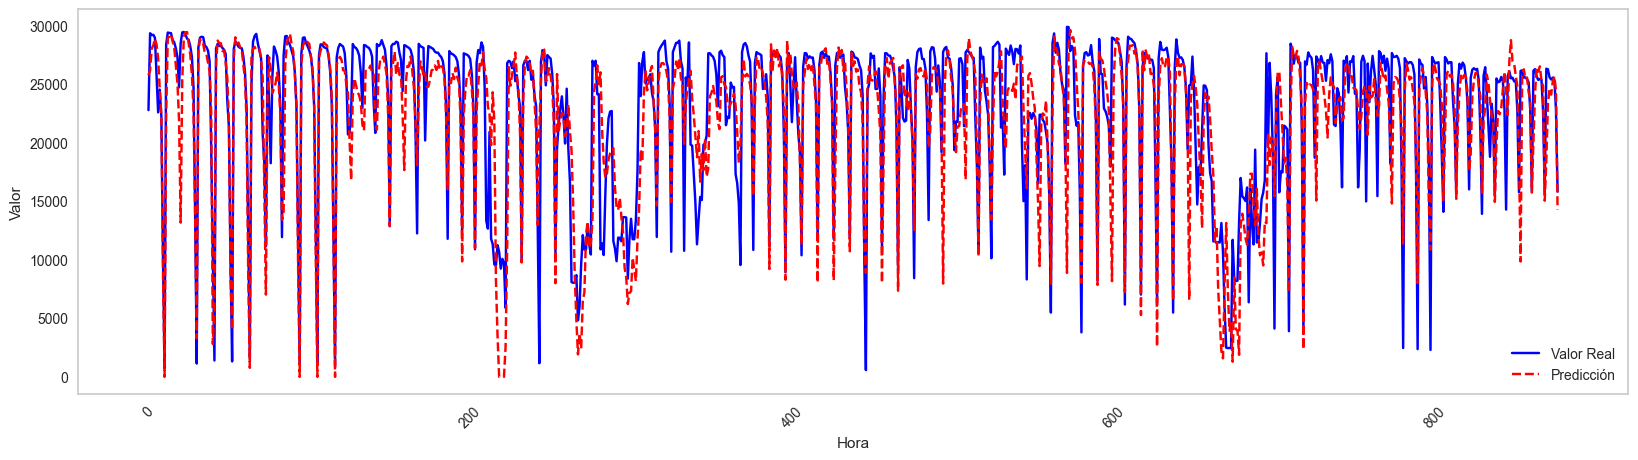

In [415]:
plot_predictions1(model_Soleado, X_Soleado_test, y_Soleado_test, scaler_y_Soleado)

Nublado

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler_Nublado_X = MinMaxScaler()
scaler_Nublado_y = MinMaxScaler()

X_Nublado_train = scaler_Nublado_X.fit_transform(X_Nublado_train.reshape(-1, X_Nublado_train.shape[-1])).reshape(X_Nublado_train.shape)
X_Nublado_val = scaler_Nublado_X.transform(X_Nublado_val.reshape(-1, X_Nublado_val.shape[-1])).reshape(X_Nublado_val.shape)
X_Nublado_test = scaler_Nublado_X.transform(X_Nublado_test.reshape(-1, X_Nublado_test.shape[-1])).reshape(X_Nublado_test.shape)

y_Nublado_train = scaler_Nublado_y.fit_transform(y_Nublado_train.reshape(-1, 1)).reshape(-1)
y_Nublado_val = scaler_Nublado_y.transform(y_Nublado_val.reshape(-1, 1)).reshape(-1)
y_Nublado_test = scaler_Nublado_y.transform(y_Nublado_test.reshape(-1, 1)).reshape(-1)

In [44]:
model_Nublado = Sequential()
model_Nublado.add(InputLayer((WINDOW_SIZE, 9)))

#CNN
model_Nublado.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'))
model_Nublado.add(BatchNormalization())
model_Nublado.add(MaxPooling1D(pool_size=2))

#model_Nublado.add(Flatten())
#BiLSTM
model_Nublado.add(Bidirectional(LSTM(128, return_sequences=True)))
model_Nublado.add(Bidirectional(LSTM(64, return_sequences=True)))
model_Nublado.add(Dropout(0.2))
model_Nublado.add(Bidirectional(LSTM(32, return_sequences=False)))

#Normalización y Dropout
model_Nublado.add(Dropout(0.1))

model_Nublado.add(Dense(16, 'relu'))
model_Nublado.add(Dense(1, 'linear'))

model_Nublado.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 5, 128)         │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 405,729 (1.55 MB)

 Trainable params: 405,601 (1.55 MB)

 Non-trainable params: 128 (512.00 B)

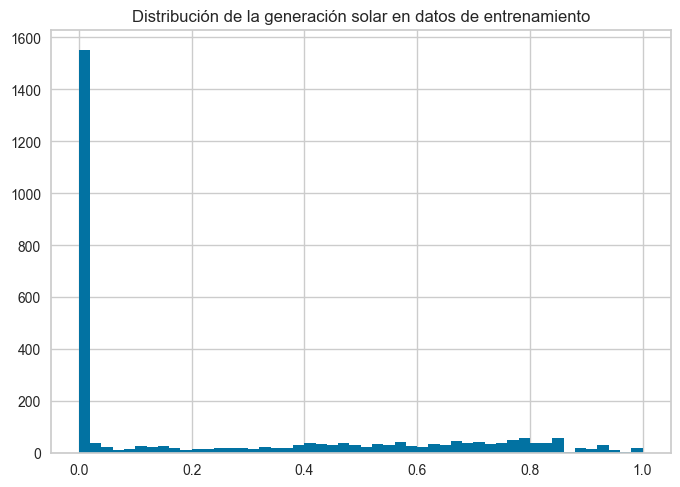

In [45]:
import matplotlib.pyplot as plt
plt.hist(y_Nublado_train, bins=50)
plt.title("Distribución de la generación solar en datos de entrenamiento")
plt.show()

In [46]:
pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
Note: you may need to restart the kernel to use updated packages.


In [50]:
from imblearn.over_sampling import SMOTE
import numpy as np

# Aplanar X para que tenga solo 2 dimensiones
X_train_flat = X_Nublado_train.reshape(X_Nublado_train.shape[0], -1)  # (samples, timesteps * features)

# Crear rangos para la generación solar (por ejemplo, 5 categorías)
bins = np.linspace(y_Nublado_train.min(), y_Nublado_train.max(), 6)  # 6 intervalos
y_train_binned = np.digitize(y_Nublado_train, bins)  # Convertir y en categorías

# Aplicar SMOTE en los datos aplanados
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled_flat, y_train_resampled_binned = smote.fit_resample(X_train_flat, y_train_binned)

# Convertir de nuevo los valores categorizados a valores continuos
y_train_resampled = bins[y_train_resampled_binned - 1]  # Asignar el valor del bin original

# Restaurar la forma original de X (desaplanar)
X_train_resampled = X_train_resampled_flat.reshape(-1, X_Nublado_train.shape[1], X_Nublado_train.shape[2])  # (samples, timesteps, features)


In [58]:
import tensorflow as tf
def weighted_mse(y_true, y_pred):
    weights = tf.where(y_true == 0, 3.0, 1.0)  # Mayor peso en valores cercanos a 0
    return tf.reduce_mean(weights * tf.square(y_true - y_pred))

In [63]:
cp2 = ModelCheckpoint('Forcasting_model_Nublado.keras', save_best_only=True)
model_Nublado.compile(optimizer=Adam(learning_rate=0.0001), loss=Huber(delta=1000), metrics=['mae'])

In [52]:
X_train_resampled.shape, y_train_resampled.shape, X_Nublado_val.shape, y_Nublado_val.shape, X_Nublado_test.shape, y_Nublado_test.shape

((10530, 10, 9), (10530,), (634, 10, 9), (634,), (633, 10, 9), (633,))

In [64]:
history2 = model_Nublado.fit(X_train_resampled, y_train_resampled, validation_data=(X_Nublado_val, y_Nublado_val), epochs=100, batch_size=16, callbacks=[cp2, early_stop])

Epoch 1/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - loss: 0.0114 - mae: 0.1078 - val_loss: 0.0341 - val_mae: 0.1717
Epoch 2/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.0096 - mae: 0.0991 - val_loss: 0.0358 - val_mae: 0.1788
Epoch 3/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.0095 - mae: 0.0982 - val_loss: 0.0330 - val_mae: 0.1755
Epoch 4/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.0088 - mae: 0.0934 - val_loss: 0.0333 - val_mae: 0.1767
Epoch 5/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.0081 - mae: 0.0903 - val_loss: 0.0361 - val_mae: 0.1785
Epoch 6/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.0080 - mae: 0.0894 - val_loss: 0.0341 - val_mae: 0.1726
Epoch 7/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0079 - mae: 0.0883 - val_loss: 0.0359 - val_mae: 0.1797
Epoch 8/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.0071 - mae: 0.0857 - val_loss: 0.0372 - val_mae: 0.1800
Epoch 9/100
659/659 ━━━━━━━━━━━━

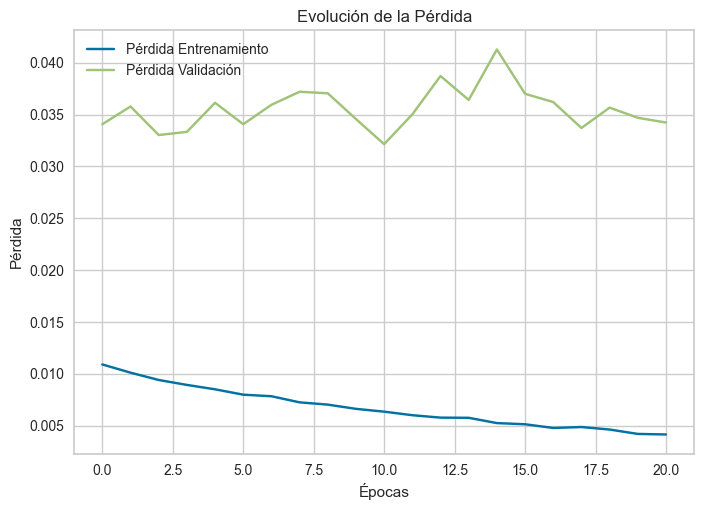

In [65]:
import matplotlib.pyplot as plt

# Extraer la pérdida del historial
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Crear la gráfica
plt.plot(train_loss, label='Pérdida Entrenamiento')
plt.plot(val_loss, label='Pérdida Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolución de la Pérdida')
plt.legend()
plt.grid(True)
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
MAE: 4871.2475
RMSE: 7253.8253
R²: 0.5671


,Predictions,Actuals
0,19061.876953,19933.0
1,15566.901367,8624.0
2,2976.493408,357.0
3,916.727539,0.0
4,0.000000,0.0
...,...,...
628,0.000000,0.0
629,0.000000,0.0
630,795.479126,0.0
631,6214.223633,23339.0


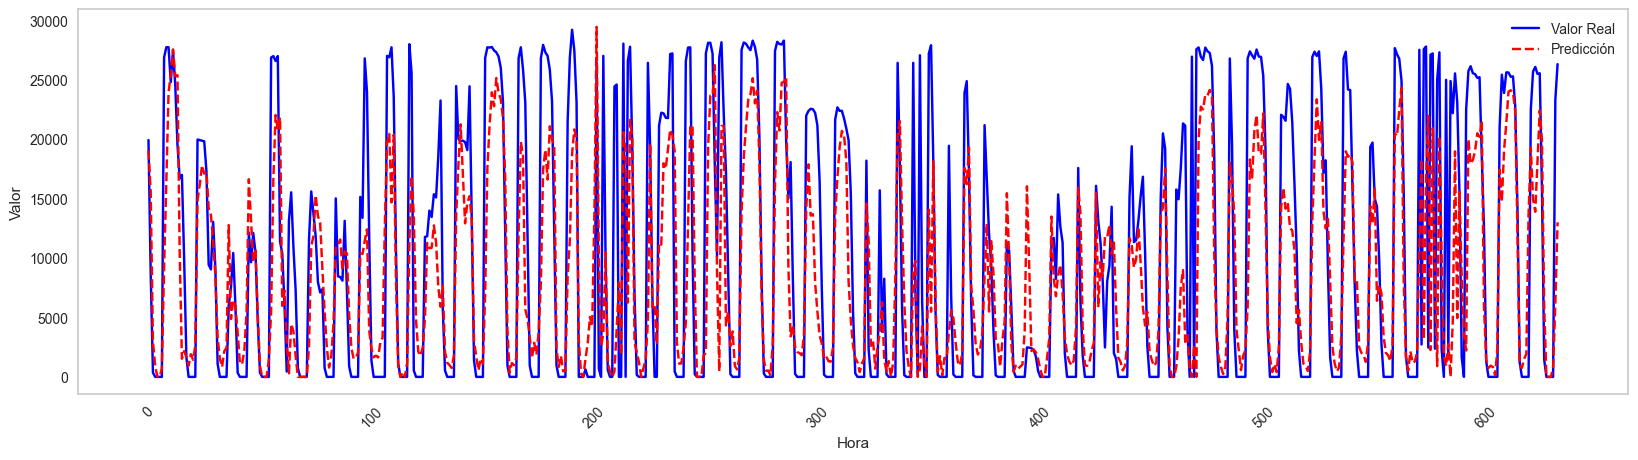

In [66]:
plot_predictions1(model_Nublado, X_Nublado_test, y_Nublado_test, scaler_Nublado_y)

Lluvioso

In [ ]:
scaler_Lluvioso_X = MinMaxScaler()
scaler_Lluvioso_y = MinMaxScaler()

X_Lluvioso_train = scaler_Lluvioso_X.fit_transform(X_Lluvioso_train.reshape(-1, X_Lluvioso_train.shape[-1])).reshape(X_Lluvioso_train.shape)
X_Lluvioso_val = scaler_Lluvioso_X.transform(X_Lluvioso_val.reshape(-1, X_Lluvioso_val.shape[-1])).reshape(X_Lluvioso_val.shape)
X_Lluvioso_test = scaler_Lluvioso_X.transform(X_Lluvioso_test.reshape(-1, X_Lluvioso_test.shape[-1])).reshape(X_Lluvioso_test.shape)

y_Lluvioso_train = scaler_Lluvioso_y.fit_transform(y_Lluvioso_train.reshape(-1, 1)).reshape(-1)
y_Lluvioso_val = scaler_Lluvioso_y.transform(y_Lluvioso_val.reshape(-1, 1)).reshape(-1)
y_Lluvioso_test = scaler_Lluvioso_y.transform(y_Lluvioso_test.reshape(-1, 1)).reshape(-1)


In [37]:
model_Lluvioso = Sequential()
model_Lluvioso.add(InputLayer((WINDOW_SIZE, 9)))

#CNN
model_Lluvioso.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'))
model_Lluvioso.add(BatchNormalization())
model_Lluvioso.add(MaxPooling1D(pool_size=2))

#model_Lluvioso.add(Flatten())
#BiLSTM
model_Lluvioso.add(Bidirectional(LSTM(128, return_sequences=True)))
model_Lluvioso.add(Bidirectional(LSTM(64, return_sequences=True)))
model_Lluvioso.add(Dropout(0.2))
model_Lluvioso.add(Bidirectional(LSTM(32, return_sequences=False)))

#Normalización y Dropout
model_Lluvioso.add(BatchNormalization())
model_Lluvioso.add(Dropout(0.3))

model_Lluvioso.add(Dense(16, 'relu'))
model_Lluvioso.add(Dense(1, 'relu'))

model_Lluvioso.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 5, 128)         │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 405,985 (1.55 MB)

 Trainable params: 405,729 (1.55 MB)

 Non-trainable params: 256 (1.00 KB)

In [38]:
cp3 = ModelCheckpoint('Forcasting_model_Lluvioso.keras', save_best_only=True)
model_Lluvioso.compile(optimizer=Adam(learning_rate=0.0001), loss=Huber(delta=1000), metrics=['mae'])

In [40]:
X_Lluvioso_train.shape, y_Lluvioso_train.shape, X_Lluvioso_val.shape, y_Lluvioso_val.shape, X_Lluvioso_test.shape, y_Lluvioso_test.shape

((3181, 10, 9), (3181,), (682, 10, 9), (682,), (681, 10, 9), (681,))

In [41]:
history3 = model_Lluvioso.fit(X_Lluvioso_train, y_Lluvioso_train, validation_data=(X_Lluvioso_val, y_Lluvioso_val), epochs=100, batch_size=16, callbacks=[cp3, early_stop])

Epoch 1/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 0.0477 - mae: 0.1424 - val_loss: 0.0306 - val_mae: 0.0938
Epoch 2/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0389 - mae: 0.1188 - val_loss: 0.0306 - val_mae: 0.0938
Epoch 3/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0380 - mae: 0.1165 - val_loss: 0.0304 - val_mae: 0.0940
Epoch 4/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0375 - mae: 0.1162 - val_loss: 0.0306 - val_mae: 0.0938
Epoch 5/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0344 - mae: 0.1067 - val_loss: 0.0288 - val_mae: 0.0911
Epoch 6/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0353 - mae: 0.1097 - val_loss: 0.0304 - val_mae: 0.0935
Epoch 7/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0373 - mae: 0.1166 - val_loss: 0.0291 - val_mae: 0.0917
Epoch 8/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0355 - mae: 0.1076 - val_loss: 0.0293 - val_mae: 0.0912
Epoch 9/100
199/199 ━━━━━━━━━━━━━━━━━━

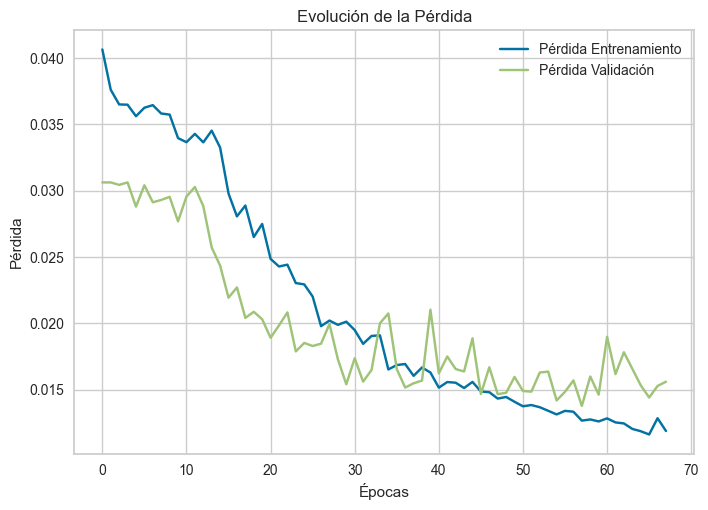

In [42]:
import matplotlib.pyplot as plt

# Extraer la pérdida del historial
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']

# Crear la gráfica
plt.plot(train_loss, label='Pérdida Entrenamiento')
plt.plot(val_loss, label='Pérdida Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolución de la Pérdida')
plt.legend()
plt.grid(True)
plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step
MAE: 1356.4561
RMSE: 3373.4678
R²: 0.7646


,Predictions,Actuals
0,0.000000,0.0
1,0.000000,0.0
2,5824.620117,0.0
3,2228.345703,0.0
4,5839.971680,0.0
...,...,...
676,0.000000,0.0
677,0.000000,0.0
678,0.000000,0.0
679,0.000000,0.0


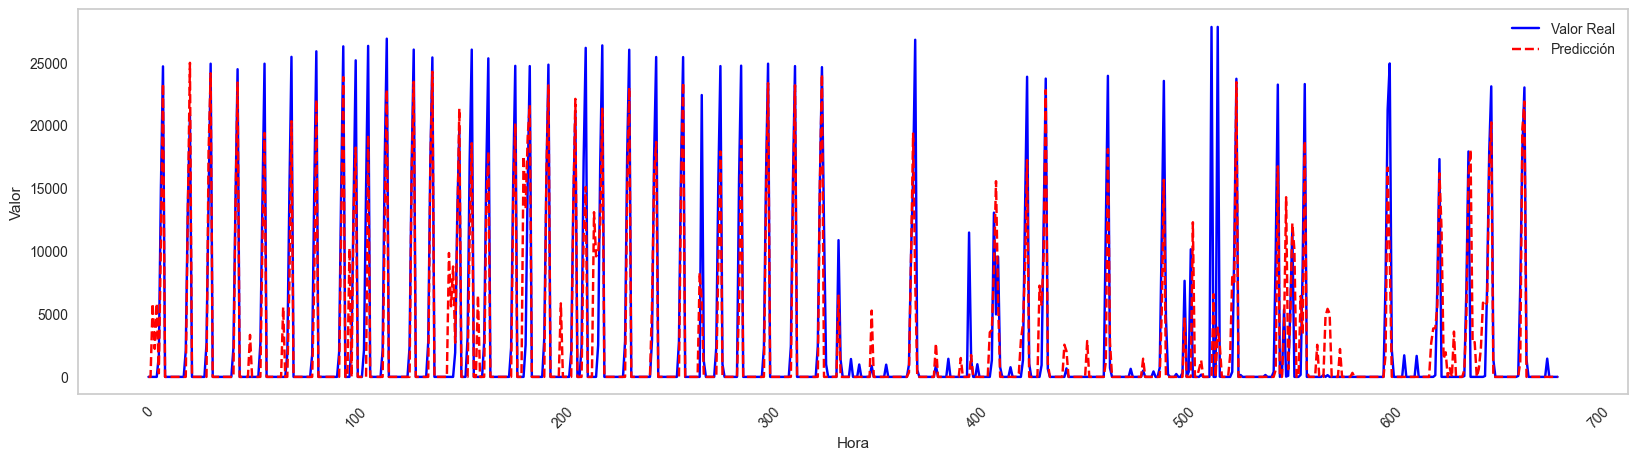

In [43]:
plot_predictions1(model_Lluvioso, X_Lluvioso_test, y_Lluvioso_test, scaler_Lluvioso_y)